<a href="https://colab.research.google.com/github/alegomezri/Image-based-EEG-Representation/blob/main/Experimento_prueba_laplacian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary functions and data

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases  #Package for database reading.
!pip install mne==0.23 #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-vklp2gr8
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-vklp2gr8
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit c35637e1a19d7cd21656496339c1dedae6714916
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.0 MB/s eta 0:00:00
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=94506 sha256=f38a7a15349ffd4fb39a1754f11b1c0cf30e966687c2e4af168f39c27b40242f
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1qvxjz9/wheels/8e/66/a7/91b78b1787a3e4d17cb82ea2da67845aa9389012c0ed8280b0
Successfully built gcpds-databases
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━

# Necessary libraries

In [ ]:
from google.colab.drive import mount
from gcpds.databases import GIGA_MI_ME
import numpy as np
import mne
from MI_EEG_ClassMeth.utils import min_max_normalization
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr, Power_based_Connectivities, Topoplot
from mne.channels import make_standard_montage
from mne import create_info
from time import time
import matplotlib
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
import os
import scipy.io as sio
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV,train_test_split
from sklearn.metrics import make_scorer, cohen_kappa_score
from pickle import load, dump
from MI_EEG_ClassMeth.Classifiers import WDCNN
from MI_EEG_ClassMeth.Preprocessing import spherical_spline_surface_laplacian

# Connect with the drive

In [ ]:
mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Create folders for results

In [ ]:
root_dir = "/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2"

In [ ]:
parent_dir = os.path.join(root_dir,'Topograms_Prueba_laplacian_Todos/')
gaussianKernel_dir = os.path.join(parent_dir,'Gaussian_Kernel/')
targets_dir = os.path.join(parent_dir,'Targets/')
os.makedirs(gaussianKernel_dir)
os.makedirs(targets_dir)

In [ ]:
parent_dir = os.path.join(root_dir,'Results_Prueba_laplacian_Todos/')
model_dir = os.path.join(parent_dir,'Models/')
grid_search_results_dir = os.path.join(parent_dir,'grid_search_results/')
os.makedirs(model_dir)
os.makedirs(grid_search_results_dir)

# Process to data

In [ ]:
seed = 23
db = GIGA_MI_ME('/content/drive/Shareddrives/GCPDS-Databases/GIGA-MI_ME')
subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects,[28,33])
fs = db.metadata['sampling_rate']

eeg_ch_names = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
index_eeg_chs = db.format_channels_selectors(channels=eeg_ch_names) - 1

montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage) #objeto de mne con el montage

f_bank = np.asarray([[8,12],[12,15],[15,20],[18,40]]) #Bandas de frecuencia
vwt = np.asarray([[2.5, 4.5]]) #recorta la señal en el tiepo de IM
tf_repr = TimeFrequencyRpr(sfreq=fs, f_bank=f_bank, vwt=vwt) #se recorta la señal y se filtra por bandas de frecuencia.
pbc = Power_based_Connectivities()#objeto de la conectividad de potencia
tp = Topoplot() #objeto de la clase
# ------------------------------------------------------------------------------
t_i = time()

#for sbj in subjects:
for sbj in [43]:
  db.load_subject(sbj)
  X, y = db.get_data(classes=['left hand mi', 'right hand mi']) # X \in R^{NxCxT}
  X = X[:,index_eeg_chs,:] #measurements units uV
  Xstd  = spherical_spline_surface_laplacian(X, info) # X esta por trials x canales x tiempo Filtro laplacian
  X_wt = tf_repr.transform(Xstd)  # X \in R^{NxCxTxWXF}
  C = pbc.transform(X_wt, type_con='gfc', gammad=1) #conectividad Kernel gaussian
  F = pbc.flow_of_connectivities(C) # flujo de conectividades kernel gaussian
  F_n = min_max_normalization(F, axis=1) #Normalización por trials

  T = tp.get_topoplot(F_n,info,save_orig_tplt=True,show=False) #Graficando el topoplot del flujo de conectivdades
  #np.save(gaussianKernel_dir+'sbj'+str(sbj),T) #Guardar los resultados de los topoplots
  #np.save(targets_dir+'sbj'+str(sbj), y) #Guardar las etiquetas
  F_n_ = np.median(F_n, axis=0)
  t_f = time() - t_i
  print('time:',round(t_f/60, 2),'m')

In [ ]:
T.shape

(200, 40, 40, 1, 1, 4)

# Guardar las conectividades

In [ ]:
seed = 23
db = GIGA_MI_ME('/content/drive/Shareddrives/GCPDS-Databases/GIGA-MI_ME')
subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects,[28,33])
fs = db.metadata['sampling_rate']

eeg_ch_names = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
index_eeg_chs = db.format_channels_selectors(channels=eeg_ch_names) - 1

montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage) #objeto de mne con el montage

f_bank = np.asarray([[8,12],[12,15],[15,20],[18,40]]) #Bandas de frecuencia
vwt = np.asarray([[2.5, 4.5]]) #recorta la señal en el tiepo de IM
tf_repr = TimeFrequencyRpr(sfreq=fs, f_bank=f_bank, vwt=vwt) #se recorta la señal y se filtra por bandas de frecuencia.
pbc = Power_based_Connectivities()#objeto de la conectividad de potencia

# ------------------------------------------------------------------------------
t_i = time()

C=list()
for sbj in list(subjects):

  db.load_subject(sbj)
  X, y = db.get_data(classes=['left hand mi', 'right hand mi']) # X \in R^{NxCxT}
  X = X[:,index_eeg_chs,:] #measurements units uV
  Xstd  = spherical_spline_surface_laplacian(X, info) # X esta por trials x canales x tiempo Filtro laplacian
  X_wt = tf_repr.transform(Xstd)  # X \in R^{NxCxTxWXF}
  C.append(pbc.transform(X_wt, type_con='gfc', gammad=1)) #conectividad Kernel gaussian

Conectividad = {}
Conectividad['GFC'] = C
path = '/content/drive/Shareddrives/GFC + WDCNN/Conectividades'
save_path= path+'GFC_laplacian_ALL'+'.mat'
sio.savemat(save_path, Conectividad)
t_f = time() - t_i
print('time:',round(t_f/60, 2),'m')

In [ ]:
F.shape

(200, 64, 1, 4)

In [ ]:
F_n.shape

(200, 64, 1, 4)

In [ ]:
F_n[0,:,:,1].shape

(64, 1)

# Topoplots por banda de frecuencia

/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


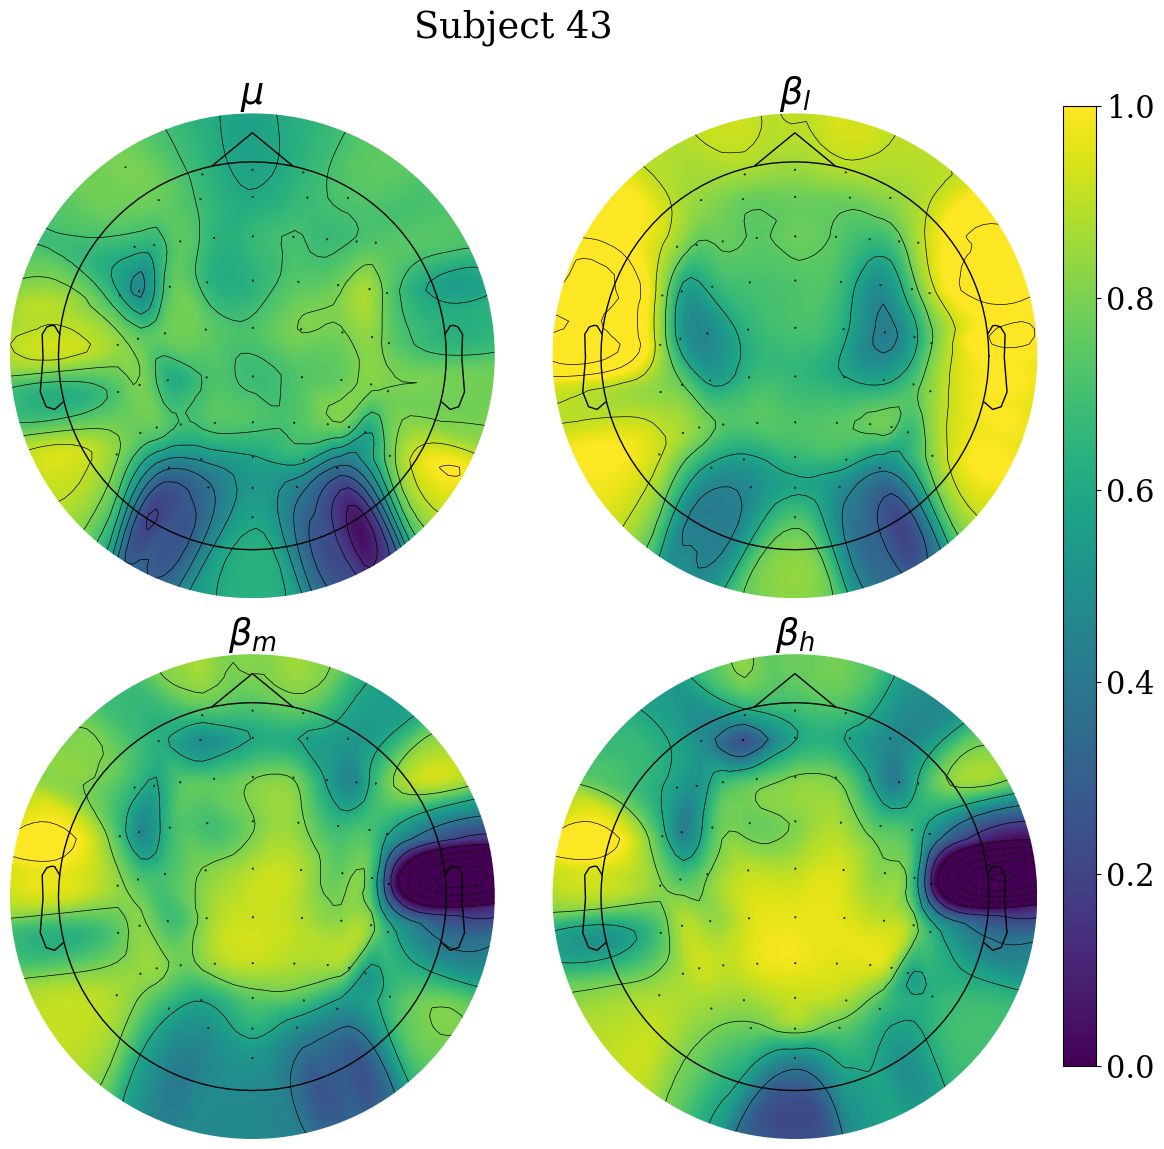

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11,12))
fig.tight_layout()
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
axs=np.ravel(axs)
im, _ = plot_topomap(F_n_[:,0,0], pos=info, vmin=0, vmax=1, cmap='viridis', axes=axs[0], contours=9, sensors=True, show=False, outlines='skirt',names=True, )
im, _ = plot_topomap(F_n_[:,0,1], pos=info, vmin=0, vmax=1, cmap='viridis', axes=axs[1], contours=9, sensors=True, show=False, outlines='skirt',names=True, )
im, _ = plot_topomap(F_n_[:,0,2], pos=info, vmin=0, vmax=1, cmap='viridis', axes=axs[2], contours=9, sensors=True, show=False, outlines='skirt',names=True, )
im, _ = plot_topomap(F_n_[:,0,3], pos=info, vmin=0, vmax=1, cmap='viridis', axes=axs[3], contours=9, sensors=True, show=False, outlines='skirt',names=True,)

for i, label in enumerate([r'$\mu$', r'$\beta_{l}$', r'$\beta_{m}$', r'$\beta_{h}$']):
  axs[i].set_title(label)

ax_x_start = 1
ax_x_width = 0.03
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('',fontsize=6)
fig.suptitle('Subject 43')
plt.subplots_adjust(top=0.9)
path = '/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2'
plt.savefig(path+'Subj43_mne24_o.png', bbox_inches='tight')
plt.show()